In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize, forest_minimize, dummy_minimize
from statistics import stdev, variance, mean
from fastai.tabular.all import *
from fastai.collab import CollabDataLoaders, collab_learner
from surprise import Reader, Dataset, accuracy, SVD
from surprise.model_selection import KFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## Exploratory Analysis

In [3]:
# Import of taining and test data
train = pd.read_csv("dados/train.csv")
test = pd. read_csv("dados/test.csv")
jokes = pd.read_csv("dados/jokes.csv")

In [4]:
# Dataset de treino
train

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375
...,...,...,...,...
1092054,9517_132,9517,132,3.156
1092055,27767_118,27767,118,-1.594
1092056,10580_81,10580,81,2.000
1092057,31007_119,31007,119,8.906


In [5]:
# Dataset de teste
test

,id,user_id,joke_id
0,6194_11,6194,11
1,19356_3,19356,3
2,23426_79,23426,79
3,40030_3,40030,3
4,19806_115,19806,115
...,...,...,...
537875,14333_74,14333,74
537876,25245_16,25245,16
537877,4082_9,4082,9
537878,19638_128,19638,128


In [6]:
# Dataset com piadas
jokes

,joke_id,joke_text
0,1,"Q. What's O. J. Simpson's web address? A. Slash, slash, backslash, slash, slash, escape."
1,2,How many feminists does it take to screw in a light bulb? That's not funny.
2,3,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
3,4,"They asked the Japanese visitor if they have elections in his country. ""Every morning,"" he answers."
4,5,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?
...,...,...
134,135,"A blonde, brunette, and a red head are all lined up to be shot to death by a firing squad. The brunette shouts, ""Tornado!"" and the riflemen turn around to see the tornado. It isn't there, and the brunette uses that time to escape. The red head yells, ""Lightning!"" and the riflemen again turn to see the disaster, yet there is no disaster and the red head escapes. The blonde yells, ""Fire!"" The riflemen do."
135,136,America: 8:00 - Welcome to work! 12:00 - Lunch break 17:00 - The work day is over Japan: 8:00 - Are you already at work? 12:00 - Continue your work 17:00 - The work day is over 20:00 - Please finish your work Romania: 8:00 - Has anyone come to work? 12:00 - Did someone start working? 16:00 - Is anyone at work?
136,137,"It was the day of the big sale. Rumors of the sale (and some advertising in the local paper) were the main reason for the long line that formed by 8:30, the store's opening time, in front of the store. A small man pushed his way to the front of the line, only to be pushed back, amid loud and colorful curses. On the man's second attempt, he was punched square in the jaw, and knocked around a bit, and then thrown to the end of the line again. As he got up the second time, he said to the person at the end of the line... ""That does it! If they hit me one more time, I won't open the store!"""
137,138,"Recently a teacher, a garbage collector, and a lawyer wound up together at the Pearly Gates. St. Peter informed them that in order to get into Heaven, they would each have to answer one question. St. Peter addressed the teacher and asked, ""What was the name of the ship that crashed into the iceberg? They just made a movie about it."" The teacher answered quickly, ""That would be the Titanic."" St. Peter let him through the gate. St. Peter turned to the garbage man and, figuring Heaven didn't really need all the odors that this guy would bring with him, decided to make the question a little ha..."


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


In [6]:
train["joke_text"] = train.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])
test["joke_text"] = test.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])

In [8]:
# Cheching uniqueness of data
train.select_dtypes(["int64", "float64", "object"]).nunique().sort_values().to_frame().T

,joke_id,Rating,user_id,id
0,139,641,40863,1092059


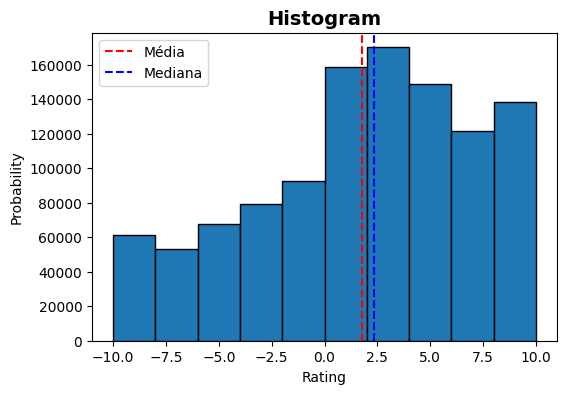

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(train.Rating, edgecolor="black")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.axvline(train.Rating.mean(), color="red", linestyle="--")
plt.axvline(train.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
plt.show()

In [10]:
# Média, desvio padrão amostral e variança amostral da feature Rating
mean(train.Rating), stdev(train.Rating), variance(train.Rating)

(1.7583939732193956, 5.2308597557955006, 27.361893784800966)

## Model

In [25]:
reader = Reader(rating_scale=(-10., 10.))
data = Dataset.load_from_df(train[["user_id", "joke_id", "Rating"]], reader)

In [26]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=2)

In [32]:
model_svd = SVD(
    n_factors=628,
    n_epochs=203,
    lr_bu=0.009388724398649437, 
    lr_bi=0.014980478328026079, 
    lr_pu=0.026445841298735544, 
    lr_qi=0.00306434987836987, 
    reg_bu=0.010422331957134049, 
    reg_bi=0.007467369368383485,
    reg_pu=0.0023025456770393864,
    reg_qi=0.08327985544490146,
    random_state=4
)

In [36]:
model_svd.fit(X_train)
predic = model_svd.test(X_test)
round(accuracy.rmse(predic), 10)

RMSE: 4.0467


4.0466527057

In [33]:
mrmse = []
kfold = 0
kf = KFold(n_splits=25, random_state=4)

for trainset, testset in kf.split(data):
    model_svd.fit(trainset)
    predic = model_svd.test(testset)
    result = round(accuracy.rmse(predic, verbose=False), 10)
    mrmse.append(result)
    kfold += 1
    print("Fold:", kfold, "RMSE:", result)
    if result <= 3.97:
        break
    
print("Média RMSE CV", mean(mrmse))

Fold: 1 RMSE: 4.0131620018
Fold: 2 RMSE: 4.0056802927
Fold: 3 RMSE: 4.0295339129
Fold: 4 RMSE: 3.9969156059
Fold: 5 RMSE: 3.9777553467
Fold: 6 RMSE: 4.0342909982
Fold: 7 RMSE: 3.9889000874
Fold: 8 RMSE: 3.9963426705
Fold: 9 RMSE: 4.0074410104
Fold: 10 RMSE: 4.007845612
Fold: 11 RMSE: 4.022778302
Fold: 12 RMSE: 4.0163756675
Fold: 13 RMSE: 4.0235271084
Fold: 14 RMSE: 4.003793578
Fold: 15 RMSE: 4.0047521226
Fold: 16 RMSE: 3.9820015094
Fold: 17 RMSE: 4.0332393466
Fold: 18 RMSE: 4.0426890185
Fold: 19 RMSE: 4.0263138633
Fold: 20 RMSE: 4.001769442
Fold: 21 RMSE: 4.0262794846
Fold: 22 RMSE: 4.0309684948
Fold: 23 RMSE: 3.9784003231
Fold: 24 RMSE: 4.0228468267
Fold: 25 RMSE: 3.9835754231
Média RMSE CV 4.010287121964


## Bayesian optimization

In [30]:
space = [
    Integer(500, 650, name="n_factors"),
    Integer(100, 250, name="n_epochs"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_bu"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_bi"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_pu"),
    Real(1e-3, 1e-1, "log-uniform", name="lr_qi"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_bu"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_bi"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_pu"),
    Real(1e-3, 1e-1, "log-uniform", name="reg_qi")
]

In [23]:
@use_named_args(space)
def svd_bayesian(**params):
    """ """
    model_svd = SVD(**params, verbose=False, random_state=5)
    model_svd.fit(X_train)
    predic = model_svd.test(X_test)
    result = round(accuracy.rmse(predic), 10)

    return result

In [31]:
# Gaussian processes
res_gp = gp_minimize(
    func=svd_bayesian, 
    dimensions=space,
    n_initial_points=5, 
    n_calls=25,
    verbose=False, 
    random_state=2
)

print('Best RMSE: %.10f' % (res_gp.fun)) 
print('Best Parameters: %s' % (res_gp.x))

RMSE: 4.0734
RMSE: 4.0639
RMSE: 9.7779
RMSE: 9.7779
RMSE: 9.7779
RMSE: 4.0791
RMSE: 4.1186
RMSE: 4.0978
RMSE: 4.0856
RMSE: 4.1272
RMSE: 4.0858
RMSE: 9.7779
RMSE: 4.0615
RMSE: 4.0697
RMSE: 4.1539
RMSE: 4.0786
RMSE: 4.0513
RMSE: 4.1069
RMSE: 4.0952
RMSE: 4.0899
RMSE: 4.1556
RMSE: 9.7779
RMSE: 4.0401
RMSE: 4.0411
RMSE: 9.7779
Best RMSE: 4.0401279227
Best Parameters: [594, 204, 0.011028970762505055, 0.01948839884817338, 0.01, 0.003462543438421947, 0.1, 0.001, 0.001, 0.1]


In [14]:
kf = KFold(n_splits=25, random_state=2)
mrmse = []

@use_named_args(space)
def svd_bayesian_cv(**params):
    """ """
    kfold = 0
    mrmse.clear()
    model_svd = SVD(**params, verbose=False, random_state=2)

    for trainset, testset in kf.split(data):
        model_svd.fit(trainset)
        predic = model_svd.test(testset)
        result = round(accuracy.rmse(predic, verbose=False), 10)
        mrmse.append(result)
        kfold += 1
        print("Fold:", kfold, "RMSE:", result)
    
    print("Média RMSE CV", mean(mrmse), "\n")
    return min(mrmse)

In [ ]:
# Gaussian processes
res_gp_cv = gp_minimize(
    func=svd_bayesian_cv, 
    dimensions=space,
    n_initial_points=5, 
    n_calls=15,
    verbose=False, 
    random_state=2
)

print('Best RMSE: %.10f' % (res_gp_cv.fun)) 
print('Best Parameters: %s' % (res_gp_cv.x))

Best RMSE: 3.9803072135
Best Parameters: [628, 203, 0.009388724398649437, 0.014980478328026079, 0.026445841298735544, 0.00306434987836987, 0.010422331957134049, 0.007467369368383485, 0.0023025456770393864, 0.08327985544490146]

Best RMSE: 4.0045086550
Best Parameters: [625, 204, 0.009521989486717746, 0.01336601625705214, 0.026640477454712163, 0.003017502613450248, 0.010572948868702966, 0.00730756395607531, 0.0023854022807244723, 0.0841150726472552]

Best RMSE: 4.0070194611
Best Parameters: [543, 117, 0.002309160264028181, 0.009740461529916337, 0.013537244049515073, 0.0027776040326523213, 0.0342753850084279]

In [ ]:
plot_convergence(res_gp)
plt.show()

## Submission

In [34]:
pred = []

for i in trange(test.shape[0]):
    pred.append((test.iloc[i, 0], model_svd.predict(test.iloc[i, 1], test.iloc[i, 2])[3]))

100%|██████████| 537880/537880 [01:28<00:00, 6083.97it/s]


In [35]:
# Gerando CSV submission
sub = pd.DataFrame(pred, columns = ["id", "Rating"])
sub.to_csv("submission.csv", index = False)